## Übung Machine Learning 1: Heart Attack - sklearn

#### Prof. Dr. Daniela Oelke
#### **Ihr Name: Hendrik Stolzke**
#### **Ihre Matrikelnummer: 190724**

### Informationen zur Aufgabe
Lesen Sie sich zunächst das gesamte Notebook durch, damit Sie die Gesamtaufgabe verstehen. 

Löschen Sie bitte vor der Abgabe unbedingt alle nicht mehr benötigten Zellen, die im Laufe der Zeit für Tests hinzugekommen sind. Bereinigen und kommentieren Sie Ihren Code.  
**2 Punkte sind für ein übersichtlich gegliedertes Notebook, gute Rechtschreibung, guter Schreibstil, etc. reserviert! Auch die geforderten Begründungen für die Entscheidungen sowie die schriftlichen Diskussionen werden in diesem Übungsblatt stark bei der Punktevergabe berücksichtigt.**

---------------------
### Aufgabenstellung

Für eine Arztpraxis soll ein System entwickelt werden, mit dem sich das Risiko eines Herzinfarkts einer Person anhand verschiedener Untersuchungen ermitteln lässt.  
Zu diesem Zweck wurde ein Datensatz mit Untersuchungsergebnissen verschiedener Personen, zusammen mit deren Risiko einen Herzinfarkt zu erleiden, erhoben.

Ihre Aufgabe ist es nun, basierend auf den erhobenen Daten einen Naive Bayes Klassifikator zur Klassifikation des Herzinfarktrisikos einer Person zu trainieren und zu evaluieren.

In [82]:
# Imports
import numpy as np
import pandas as pd

### Laden des Datensatzes

In [83]:
# Laden des "heart" Datensatzes
data = pd.read_csv('./DATA/heart.csv')
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,male,3,145,233,True,0,150,no,2.3,0,0,1,high risk
1,37,male,2,130,250,False,1,187,no,3.5,0,0,2,high risk
2,41,female,1,130,204,False,0,172,no,1.4,2,0,2,high risk
3,56,male,1,120,236,False,1,178,no,0.8,2,0,2,high risk
4,57,female,0,120,354,False,1,163,yes,0.6,2,0,2,high risk


<Figure size 800x600 with 0 Axes>

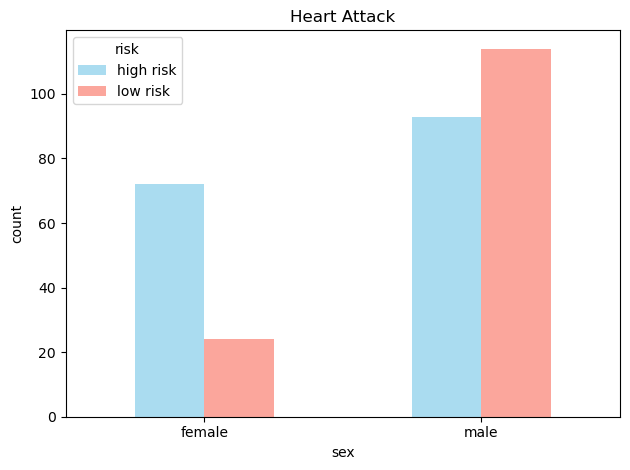

In [84]:
import pandas as pd
import matplotlib.pyplot as plt

# Laden des "heart" Datensatzes
data = pd.read_csv('./DATA/heart.csv')

# Balkendiagramm für die Risikospalte aufgeschlüsselt nach Geschlecht erstellen
plt.figure(figsize=(8, 6))

# Gruppierung nach Geschlecht und Zählen der Risiken
grouped = data.groupby(['sex'])['target'].value_counts().unstack()

# Erstellung von Balkendiagrammen
grouped.plot(kind='bar', color=['salmon', 'skyblue'], alpha=0.7)
plt.title('Heart Attack')
plt.xlabel('sex')
plt.ylabel('count')
plt.xticks(rotation=0)
plt.legend(title='risk')
plt.tight_layout()
plt.show()


### Teil 1: Untersuchung des Datensatzes (4 Punkte)

Machen Sie sich durch zusammenfassende Statistiken / Graphiken / Lesen der Informationen zu den Attributen usw. mit den Daten vertraut. Fassen Sie wichtige Erkenntnisse, auf deren Basis Sie später weitere Entscheidungen für die verwendeten Methoden treffen, jeweils kurz in einer Markdown-Zelle zusammen.  
(Hinweis: Mit den "weiteren Entscheidungen" sind so Dinge gemeint wie, ob Sie eine Normalisierung brauchen und falls ja, welche; ob Encodings geändert werden müssen und falls ja, welche Art von Encoding verwendet werden müsste; auf welchen Spalten das jeweils angewendet werden sollte; welche Art des Samplings Sie verwenden sollten usw. Überlegen Sie: Welche Informationen über die Daten müssen Sie haben, um diese Entscheidungen später gut treffen zu können?)

In [85]:
data.size

4242

Mit 'size' kann ich herausfinden, wie groß der Datensatz tatsächlich ist. Die Größe beträgt 4242 Daten.

In [86]:
data.head(3)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,male,3,145,233,True,0,150,no,2.3,0,0,1,high risk
1,37,male,2,130,250,False,1,187,no,3.5,0,0,2,high risk
2,41,female,1,130,204,False,0,172,no,1.4,2,0,2,high risk


Ordinal Encoding:

Anhand des Datensatzes wäre es besonders vorteilhaft, wenn alle Merkmale binär vorliegen würde, wobei 1 für 'True' und 0 für 'False' steht. Dieses Verfahren wird in der Fachsprache Encoding bezeichnet.
Um sicherzustellen, dass alles perfekt vorliegt, müssen wir die einzelnen Merkmale analysieren. Nehmen wir zum Beispiel das Merkmal Geschlecht. Statt 'female' und 'male' kann eine ordinale Codierung verwendet werden, bei der '1' für 'female' und '0' für 'male' steht. Ähnlich vorteilhaft kann dies auch für die Merkmale 'fbs', 'exang' und 'target' sein. Wobei 'target' als Zielmerkmal gesondert zu behandeln ist. In unserem Fall muss das 'target' nicht extra Umgewandelt werden, da die Pipeline dies bereits automatisch macht. Dies wurde erst seit einem neuen Update ermöglicht. Ansonsten gibt es hierführ speziell den Label Encoder.

One-Hot-Encoding:

Bei Merkmalen, die mehr als 2 Zustände haben wird One-Hot-Encoding verwendet. Dabei werden für jedes Untermerkmal neue Spalten erstellt. Beispiel: Das Ergebnis des Ruhe-Elektrokardiogramms. Dieses Merkmal kann eine von drei möglichen Zuständen aufweisen, die in unserem Datensatz mit den Zahlen 0, 1 und 2 bezeichnet sind. 
Wenn der Zustand 0 vorliegt, also bei einem Patienten auftritt, wird in der Spalte für Zustand 0 eine 1 eingetragen, während in den beiden anderen Zustandsspalten eine 0 steht. Dies wird auch auf alle anderen Zustandsspalten angewendet. Auf diese Weise wird das Merkmal 'restecg' im Datensatz codiert. Im Datensatz gibt es weitere Merkmale, die sich für die One-Hot-Encoding eignen. Ich würde dies auch auf 'ca', 'thal', 'slope' und 'cp' anwenden, da hier mehr als nur True oder False gibt. Mit mehr als 2 Zuständen!

Normalisierung:

Die Datentypen, die einen größeren Wertebereich mit mehreren Zustände (stetig und nicht mehr diskret) haben, wie das Alter 'age', 'trestbps', 'chol', 'thalach' und 'oldpeak', sollten mit der Min/Max-Funktion normalisiert werden. Eine Normalisierung ist hier besonders sinnvoll, da hier aus hohen, kleinen usw. Werten wie zum Beispiel beim Alter zwischen 0 und 100+ auf einen Bereich zwischen 0 und 1 skaliert werden kann. 

In [87]:
data.describe()

,age,cp,trestbps,chol,restecg,thalach,oldpeak,slope,ca,thal
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.966997,131.623762,246.264026,0.528053,149.646865,1.039604,1.399340,0.729373,2.313531
std,9.082101,1.032052,17.538143,51.830751,0.525860,22.905161,1.161075,0.616226,1.022606,0.612277
min,29.000000,0.000000,94.000000,126.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,120.000000,211.000000,0.000000,133.500000,0.000000,1.000000,0.000000,2.000000
50%,55.000000,1.000000,130.000000,240.000000,1.000000,153.000000,0.800000,1.000000,0.000000,2.000000
75%,61.000000,2.000000,140.000000,274.500000,1.000000,166.000000,1.600000,2.000000,1.000000,3.000000
max,77.000000,3.000000,200.000000,564.000000,2.000000,202.000000,6.200000,2.000000,4.000000,3.000000


Durch '.describe()' kann ich statistisch herausfinden, bei welchen der Merkmale welches Encoding am effektivsten wäre. Meine Entscheidungen mache ich abhängig von den Werten des arithmetischen Mittels, der Standardabweichung, der Quartilen, des Minimum und Maximum. Zusätzlich schaue ich mir den Datensatz selbst an, um direkt festzustellen, ob die Merkmale ordinal, nominal, kategorisch oder metrisch sind, basierend auf den durch '.dtypes' angezeigten Datentypen der einzelnen Merkmale. Anhand dieser Informationen kann ich die Auswahl der Zuordnung der Encodings treffen, wie oben bei den verschiedenen Encoding-Arten beschrieben.

In [88]:
data.dtypes

age           int64
sex          object
cp            int64
trestbps      int64
chol          int64
fbs            bool
restecg       int64
thalach       int64
exang        object
oldpeak     float64
slope         int64
ca            int64
thal          int64
target       object
dtype: object

In [89]:
data.target.describe()

count           303
unique            2
top       high risk
freq            165
Name: target, dtype: object

Durch Auswahl des Merkmals, kann auch die statistische Eigenschaft wieder mit '.describe()' aufgezeigt werden.

### Teil 2: Vorbereitung des Datensatzes (2 Punkte)

Bereiten Sie den Datensatz zur weiteren Verarbeitung vor:
* Teilen Sie die Daten in Features (X) und Zielvariable (y) auf.
* Teilen Sie die Daten in Test- und Trainingsdaten auf.

Zuerst würde ich den Datensatz aufspalten auf y die Zielvariable und der Rest auf X als Feature. 

In [90]:
X = data.drop('target', axis=1)
y = data.target
print('X:\n', X.head(3),'\n\ny:\n', y.head(3))

X:
    age     sex  cp  trestbps  chol    fbs  restecg  thalach exang  oldpeak  \
0   63    male   3       145   233   True        0      150    no      2.3   
1   37    male   2       130   250  False        1      187    no      3.5   
2   41  female   1       130   204  False        0      172    no      1.4   

   slope  ca  thal  
0      0   0     1  
1      0   0     2  
2      2   0     2   

y:
 0    high risk
1    high risk
2    high risk
Name: target, dtype: object


Ich habe die oberen drei Zeilen des neuen Datensatzes ausgegeben.
Daraus kann man sehen, dass alle Merkmale erhalten geblieben sind. Jedoch wurde das Merkmal 'target' aus dem Datensatz in einer neuen Variablen y gespeichert, während die Variable X nun dieses Merkmal nicht mehr enthält. Die Variable X enthält nun alle Merkmale/Features, die der Algorithmus lernen soll, um eine Entscheidung y zu treffen. Diese Entscheidung gibt beispielsweise einem Arzt Auskunft darüber, ob der betroffene Patient ein hohes Risiko für einen Herzinfarkt hat oder nicht.

Nun gilt es die Datensätze X und y in jeweils Test- und Trainingsdatensätze aufzuteilen. Am Ende sollten 4 Datensätze vorliegen.

In [91]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

Ich habe mich dafür entschieden, den Datensatz in ein 90 zu 10 Verhältnis aufzuteilen. Das bedeutet, dass 90% der Daten für das Training des Systems verwendet werden und die verbleibenden 10% zum Evaluieren und Testen des trainierten Systems dient.
 
Mit Random State wird eine Deterministische Ausführung des Codes möglich. Dies bezieht sich beim Split in erster Linie auf die gleiche Abspaltung der Daten, damit diese immer gleich bleibt bei jeder Ausführung. 

### Teil 3: Erzeugung einer Pipeline (7 Punkte)

Erzeugen Sie eine Pipeline zur Bearbeitung des Datensatzes.

Die Pipeline soll:
1. alle erforderliche Vorverarbeitungsschritte beinhalten (wie das Ändern des **Encodings** oder die **Normalisierung** einzelner Spalten, ggf. aber auch weitere Vorverarbeitungen)
2. eine Klassifikation anhand des Naive-Bayes Klassifikators durchführen

Überlegen Sie bitte jeweils, welche der unterschiedlichen in der Vorlesung eingeführten Methoden zur Datenvorverarbeitung für die vorliegenden Daten sinnvoll sind. Kommentieren Sie Ihren Code und begründen Sie Ihre Entscheidungen. Achten Sie auf die korrekte Reihenfolge der durchzuführenden Aktionen!

*sklearn* stellt eine Auswahl an verschiedenen Naive Bayes Ansätzen zur Verfügung: https://scikit-learn.org/stable/modules/naive_bayes.html. Nutzen Sie den *Gaussian Naive Bayes* Ansatz. 

Ich habe unter Teil 1 den Datensatz Untersucht und bin auf den Entschluss gekommen, dass zum Encoden des Datensatzes ein Ordinaler Encoder, ein OneHot Encoder und zur Normalisierung ein MinMaxScaler verwendet werden soll. Diese werden über 'sklearn.preprocessing' importiert. 



Um alle Encodings in einer Pipeline anwenden zu können, habe ich mich für den ColumnTransformer entschieden. Diesen importiere ich über '.compose' und fülle ihn mit den zu änderenden Merkmalen/Features und dem entsprechenden Encoding-Typ.

In [92]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, MinMaxScaler

cTransform = ColumnTransformer(transformers=[
    ('Ordinal', OrdinalEncoder(), ['sex','fbs','exang']),
    ('OneHot', OneHotEncoder(sparse=True), ['ca', 'thal', 'restecg', 'slope', 'cp']),
    ('Normalisierung', MinMaxScaler(),['age', 'trestbps', 'chol', 'thalach', 'oldpeak'])
])

Ich habe vor den Column Transformer als ersten Schritt in meiner Pipeline aufzurufen. Dies ist notwendig, um die Daten vorzuverarbeiten, bevor der Gaussian Naive Bayes-Schritt durchgeführt wird, da dieser die Daten in der Form nach dem Encoding und der Normalisierung benötigt.

In [93]:
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import GaussianNB

nbay= GaussianNB()
pipeline = make_pipeline(cTransform,nbay)


Durch die Verwendung von 'sklearn.pipeline' und '.naive_bayes' importiere ich nun 'make_pipeline' für die Pipeline und den zu verwendenen Gaussian Naives Bayes-Ansatz. 

Zuallererst deklariere ich die neue Pipeline und übergebe dann den Vorverarbeitungsschritt vom ColumnsTranformer als ersten Schritt und den Gaussian Naive Bayes als zweiten Schritt.

Als nächstes passen wir die pipeline mit dem '.fit'-Aufruf an und übergeben die Trainingsdaten X und y aus dem Datensatz.

In [94]:
pipeline.fit(X_train, y_train)

c:\Users\hendr\anaconda3\envs\projekt1\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('Ordinal', OrdinalEncoder(),
                                                  ['sex', 'fbs', 'exang']),
                                                 ('OneHot',
                                                  OneHotEncoder(sparse=True),
                                                  ['ca', 'thal', 'restecg',
                                                   'slope', 'cp']),
                                                 ('Normalisierung',
                                                  MinMaxScaler(),
                                                  ['age', 'trestbps', 'chol',
                                                   'thalach', 'oldpeak'])])),
                ('gaussiannb', GaussianNB())])

Der Fit-Schritt darf NUR und ausschließlich nur auf Trainingsdaten erfolgen, da der Algorithmus auf diesen lernt wird und sich daran anpasst. Bei anderen Machine Learning Klassifikatoren/Modellen würde dann auf alle Daten, egal ob Test oder Training, noch ein '.transform(...)'-Anweisung erfolgen, um den gefitteten/angepassten Algorithmus auf den Daten anzuwenden und auszuführen.

In [95]:
y_pred = pipeline.predict(X_test)

Vorhersagen nach dem Lernen werden durch '.predict(...)' mit Übergabewert aufgerufen. Der Übergabewert ist in unserem Fall der Testdatensatz X.

Durch die Funktion '.predict(...)' wird dann die Zielvariable aus den vorhergesagten Werten als 'y_pred' zurückgegeben. 

Wenn, wie in unserem Fall, alle Daten für y vorhanden sind, kann die Genauigkeit berechnet werden. Siehe erläuterung in Teil 4.

In [96]:
pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('Ordinal', OrdinalEncoder(),
                                                  ['sex', 'fbs', 'exang']),
                                                 ('OneHot',
                                                  OneHotEncoder(sparse=True),
                                                  ['ca', 'thal', 'restecg',
                                                   'slope', 'cp']),
                                                 ('Normalisierung',
                                                  MinMaxScaler(),
                                                  ['age', 'trestbps', 'chol',
                                                   'thalach', 'oldpeak'])])),
                ('gaussiannb', GaussianNB())])

Wenn man einfach nur die Pipeline ausgibt, sieht man alle Pipeline Schritte und was ich gemacht habe.

### Teil 4: Evaluation (5 Punkte)

Evaluieren Sie Ihr Modell (Pipeline), indem Sie die Klassifikationsgenauigkeit (Accuracy) und die Confusion Matrix auf den Testdaten bestimmen.

Interpretieren Sie die Ergebnisse in Bezug auf die Problemstellung (schriftlich).

(Hinweis: Bevor Sie die Klassifikationsgenauigkeit bzw. die Confusion matrix Ihres Modells bestimmen können, müssen Sie es natürlich erst noch trainieren.)

Für die Bestimmung der Genauigkeit verwende ich die Funktion 'accuracy_score' aus 'sklearn.metrics', um die Genauigkeit meines Modells zu testen. Dafür übergebe ich 'accuracy_score' die vorhergesagten y-Werte und die tatsächliche Lösung.  

In [97]:
from sklearn.metrics import accuracy_score

print(f'{round(accuracy_score(y_test,y_pred)*100,4)}% Accuracy')

90.3226% Accuracy


Die Genauigkeit beträgt 90,32% und wird aus den Fehlern der Vorhersagen im vergleich zu den tatsächlichen Lösungen berechnet. Im Grunde ist dies die Warscheinlichkeit, mit der das Modell/der Algorithmus richtige Aussagen trifft. Auf 100 Personen würden etwa 90 Personen richtige Untersuchungsergebnisse erhalten. Der Fehler hingegen gibt an, dass etwa 10 Personen ein falsches Ergebnis erhalten würden. 

Die Confusion Matrix und das anzeigen der Matrix als Plot kann über 'sklearn.metrics' importiert werden.

In [98]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=pipeline.classes_)

cm wird als neue Variable deklariert und erhält die Werte, die beim Aufruf von der Confusion Matrix mit den Vorhergesagten Werten plus die Überprüfung anhand der Lösung zurückgegeben werden. Durch ConfusionMatrixDisplay(...) mit Übergabe der Werte aus der Confusionsmatrix und die Labels dazu, kann nun diese geplottet/geprintet werden. Dafür wird nunoch der '.plot()' Aufruf benötigt.

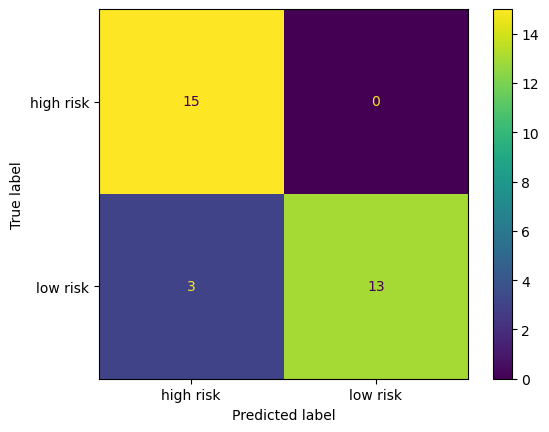

In [99]:
disp.plot()

Anhand der Confusionsmatrix wird deutlich, dass von 31 Vorhersagen 15 Personen richtig als hohes Risiko und 13 Personen richtig als niedriges Risiko klassifiziert wurden. Leider gibt es auch fehlerhafte Kassifizierungen, bei denen Personen fälschlicherweise als hohes Risiko eingestuft wurden, obwohl sie ein niedriges Risiko haben. Die Anzahl solcher falschen Klassifikationen beträgt 3.

Würde hier die Accuracy berechnet werden, würde diese wie oben berechnet mit 'accuracy_score' bei 90,32% liegen.

Aus den falsch positiven und falsch negativen Ergebnis geht hervor, dass mehr Personen mit einem niedrigen Risiko für einen Herzinfarkt falsch als hohes Risiko klassifiziert wurden, anstatt andersherum.

Dies ist eher unbedenklich, da bei einem hohen Risiko die Arztpraxis die betroffene Person mehr Beachtung schenken müsste, um auf das Schlimmste vorbereitet zu sein und einen Herzinfarkt zu vermeiden. Prinzip: Lieber einmal zu viel Warnen als einmal zu wenig!